In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Using TensorFlow backend.


In [2]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [3]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 10 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 30

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [5]:
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1653 images belonging to 7 classes.
Time:  0:12:26.704008


In [6]:
#__Validation Data this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 422 images belonging to 7 classes.
Time:  0:03:00.378477


In [7]:
#__Test Data this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 400 images belonging to 7 classes.
Time:  0:02:58.314204


In [10]:

#loading training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 1653 images belonging to 7 classes.


In [11]:
#loading validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 422 images belonging to 7 classes.


In [12]:
#loading testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 400 images belonging to 7 classes.


In [13]:
#Training Model .this is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=10,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

C:\Users\user\Anaconda3\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 1653 samples, validate on 422 samples
Epoch 1/10
1653/1653 [==============================] - 2s 1ms/step - loss: 1.5724 - acc: 0.4229 - val_loss: 1.2651 - val_acc: 0.5024
Epoch 2/10
1653/1653 [==============================] - 2s 965us/step - loss: 0.9703 - acc: 0.6812 - val_loss: 1.0374 - val_acc: 0.6517
Epoch 3/10
1653/1653 [==============================] - 2s 996us/step - loss: 0.7023 - acc: 0.7768 - val_loss: 0.8315 - val_acc: 0.7038
Epoch 4/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.5591 - acc: 0.8221 - val_loss: 0.7890 - val_acc: 0.7488
Epoch 5/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4553 - acc: 0.8512 - val_loss: 0.7486 - val_acc: 0.7062
Epoch 6/10
1653/1653 [==============================] - 2s 958us/step - loss: 0.3988 - acc: 0.8808 - val_loss: 0.7401 - val_acc: 0.7180
Epoch 7/10
1653/1653 [==============================] - 2s 981us/step - loss: 0.3377 - acc: 0.9026 - val_loss: 0.5276 - val_acc: 0.8483
Epoch 8

In [15]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 357       
Total params: 2,514,307
Trainable params: 2,514,307
Non-trainable params: 0
____________________________________________

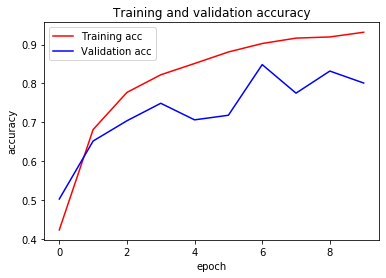

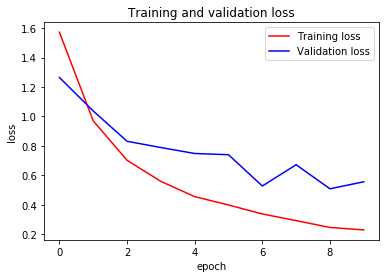

In [16]:
#Plotting our training and validation Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [18]:
#model evaluation on Testing Data set
model.evaluate(test_data, test_labels)

400/400 [==============================] - 0s 218us/step


[1.0833026355504989, 0.6324999928474426]

In [19]:
#plotting Calssification and confusion matrices
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[ 5.81325352e-01 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     7.09739864e-01 -0.00000000e+00]
   [ 1.34747589e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     3.83629590e-01 -0.00000000e+00]
   [ 1.20213389e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.03853148e-01 -0.00000000e+00]
   ...
   [ 1.79209328e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.88714427e-01 -0.00000000e+00]
   [ 2.42937732e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     7.39734352e-01 -0.00000000e+00]
   [ 1.34511435e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     5.79166353e-01 -0.00000000e+00]]

  [[ 5.41222334e-01 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.92045671e-01 -0.00000000e+00]
   [ 1.29997265e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     3.18472832e-01 -0.00000000e+00]
   [ 1.14575744e+00 -0.00000000e+00  1.87204152e-01 ... -0.00000000e+00
     4.55556273e-01 -0.00000000e+00]


rounded test_labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [20]:
animals = ['Bipolar', 'Clipper', 'Grasper', 'Hook','Irrigator','Scissor', 'Specimen_Bag']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

     Bipolar       0.70      0.95      0.81        65
     Clipper       0.56      0.66      0.61        62
     Grasper       0.73      0.36      0.48        66
        Hook       0.76      0.69      0.72        54
   Irrigator       0.58      0.13      0.22        53
     Scissor       1.00      0.49      0.66        43
Specimen_Bag       0.79      0.74      0.76        57

   micro avg       0.71      0.58      0.64       400
   macro avg       0.73      0.57      0.61       400
weighted avg       0.72      0.58      0.61       400
 samples avg       0.58      0.58      0.58       400



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [21]:
#Confusion matrix
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [22]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [23]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


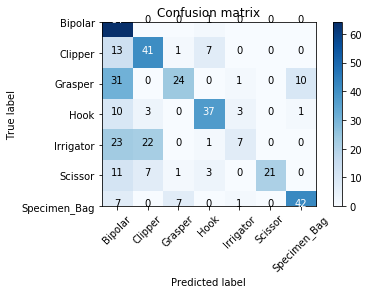

In [24]:
plot_confusion_matrix(confusion_matrix, ['Bipolar', 'Clipper', 'Grasper', 'Hook','Irrigator','Scissor', 'Specimen_Bag'])

Normalized confusion matrix


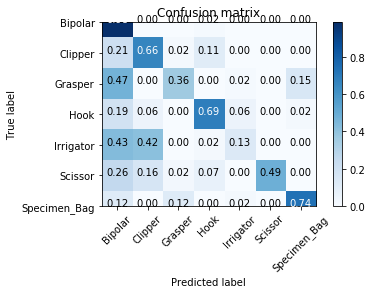

In [25]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['Bipolar', 'Clipper', 'Grasper', 'Hook','Irrigator','Scissor', 'Specimen_Bag'],
                     normalize=True)

In [26]:
def read_image(file_path):
    print("[INFO] loading and preprocessing images...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [27]:
def test_single_image(path):
    animals = ['Bipolar', 'Clipper', 'Grasper', 'Hook','Irrigator','Scissor', 'Specimen_Bag']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,7), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print(' Prediction:')
    time.sleep(.5)
    #for x in range(2):
        #print('.'*(x+1))
        #time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [32]:
path = 'data/test/Irrigator/v10_064125.jpg'

[INFO] loading and preprocessing images...
ID: 0, Label: Bipolar 51.79%
ID: 1, Label: Clipper 0.78%
ID: 2, Label: Grasper 31.57%
ID: 3, Label: Hook 0.71%
ID: 4, Label: Irrigator 6.55%
ID: 5, Label: Scissor 5.96%
ID: 6, Label: Specimen_Bag 2.65%
 Prediction:
ID: 0, Label: Bipolar


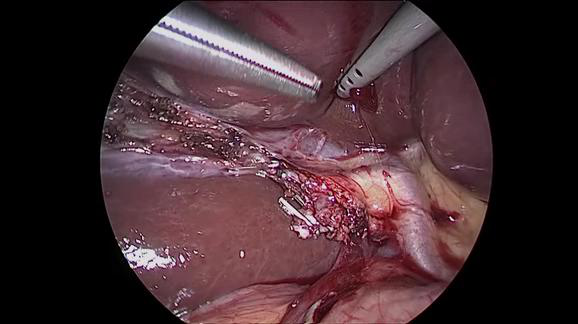

In [33]:
test_single_image(path)